In [1]:
import pandas as pd
train_data = pd.read_csv('/Users/subhiksha/Documents/NLP/NLP project/FinalProjectData/kagglemoviereviews/corpus/train.tsv',sep='\t')
test_data = pd.read_csv('/Users/subhiksha/Documents/NLP/NLP project/FinalProjectData/kagglemoviereviews/corpus/test.tsv',sep='\t')


/var/folders/vz/f5vgmcvn1qj10g0cxg7v5bd40000gn/T/ipykernel_50363/2924858184.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = train_data


In [3]:
df['Phrase']=df['Phrase'].str.lower().str.replace('[^\w\s]','').str.replace('\d+','').str.replace('\n',' ').replace('\r','').str.replace("[^a-zA-Z0-9\s]",'') 


In [4]:
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

STOPWORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

df['Phrase'] = df['Phrase'].apply(lambda x: word_tokenize(str(x).lower()) if pd.notnull(x) else [])
df['Phrase'] = df['Phrase'].apply(lambda x: [word for word in x if word not in STOPWORDS])
df['Phrase'] = df['Phrase'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
df['Phrase'] = df['Phrase'].apply(lambda x: " ".join(x))




In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences  

tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(df['Phrase'].values)
sequences = tokenizer.texts_to_sequences(df['Phrase'].values)
df_dtm=pad_sequences(sequences, maxlen=200)

df_train_dtm = df_dtm[:train_data.shape[0]]
df_test_dtm = df_dtm[train_data.shape[0]:]

/Users/subhiksha/Documents/NLP/Venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [6]:
df_dtm.shape


(156060, 200)

In [7]:
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.layers import Dense, Flatten, Dropout, LSTM, Embedding, Bidirectional, BatchNormalization
from keras.regularizers import l1_l2

model=Sequential()

model.add(Embedding(20000, 300, input_length=df_train_dtm.shape[1])),
model.add(Bidirectional(LSTM(64,  activation='relu'))),
model.add(Flatten())

model.add(Dense(16, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(16, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(5, activation='softmax'))


/Users/subhiksha/Documents/NLP/Venv/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [8]:
from tensorflow.keras.utils import to_categorical
from keras.optimizers import Adam

learning_rate = 0.0005  
optimizer = Adam(learning_rate=learning_rate)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(df_train_dtm, to_categorical(train_data.Sentiment.values), validation_split=0.20, epochs=14, batch_size=256, verbose=1)

Epoch 1/14
488/488 ━━━━━━━━━━━━━━━━━━━━ 260s 531ms/step - accuracy: 0.3206 - loss: 1.8746 - val_accuracy: 0.4985 - val_loss: 1.2837
Epoch 2/14
488/488 ━━━━━━━━━━━━━━━━━━━━ 272s 557ms/step - accuracy: 0.5313 - loss: 1.3080 - val_accuracy: 0.5597 - val_loss: 1.1365
Epoch 3/14
488/488 ━━━━━━━━━━━━━━━━━━━━ 242s 495ms/step - accuracy: 0.5816 - loss: 1.1096 - val_accuracy: 0.5674 - val_loss: 1.0867
Epoch 4/14
488/488 ━━━━━━━━━━━━━━━━━━━━ 240s 492ms/step - accuracy: 0.6120 - loss: 1.0124 - val_accuracy: 0.5720 - val_loss: 1.0754
Epoch 5/14
488/488 ━━━━━━━━━━━━━━━━━━━━ 236s 484ms/step - accuracy: 0.6325 - loss: 0.9497 - val_accuracy: 0.5875 - val_loss: 1.0447
Epoch 6/14
488/488 ━━━━━━━━━━━━━━━━━━━━ 237s 485ms/step - accuracy: 0.6581 - loss: 0.8800 - val_accuracy: 0.5823 - val_loss: 1.0674
Epoch 7/14
488/488 ━━━━━━━━━━━━━━━━━━━━ 243s 497ms/step - accuracy: 0.6753 - loss: 0.8337 - val_accuracy: 0.5826 - val_loss: 1.0541
Epoch 8/14
488/488 ━━━━━━━━━━━━━━━━━━━━ 345s 707ms/step - accuracy: 0.6873 -

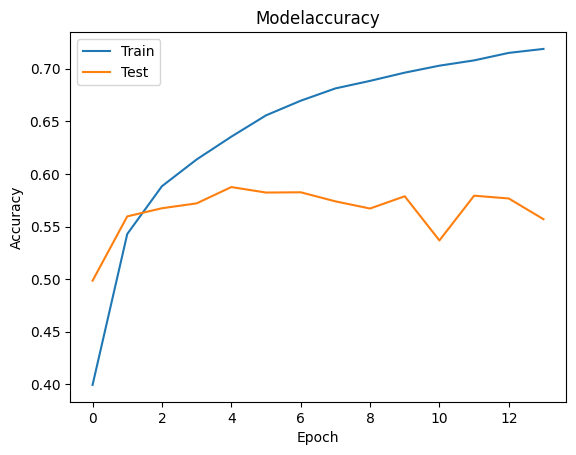

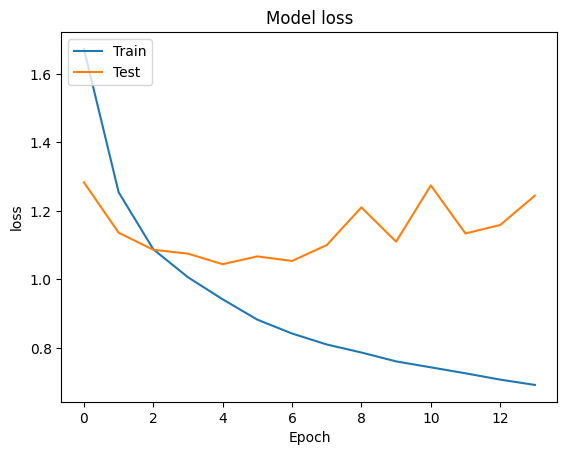

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Modelaccuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train","Test"],loc="upper left")
plt.show()

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("loss")
plt.xlabel("Epoch")
plt.legend(["Train","Test"],loc="upper left")
plt.show()